In [1]:
import pandas as pd
import numpy as np

from scipy import signal
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)

Random Seed:  999


In [3]:
gw_df = pd.read_csv('../data/input/richers_1764.csv')
parameters_df = pd.read_csv('../data/input/richers_1764_parameters.csv')
selected_indexes = parameters_df[parameters_df['beta1_IC_b'] > 0].index
gw_df = gw_df.iloc[:, selected_indexes]
gw_df = gw_df.iloc[(407-256):407, :]

### Signal Analysis

#### 3 Random Signals

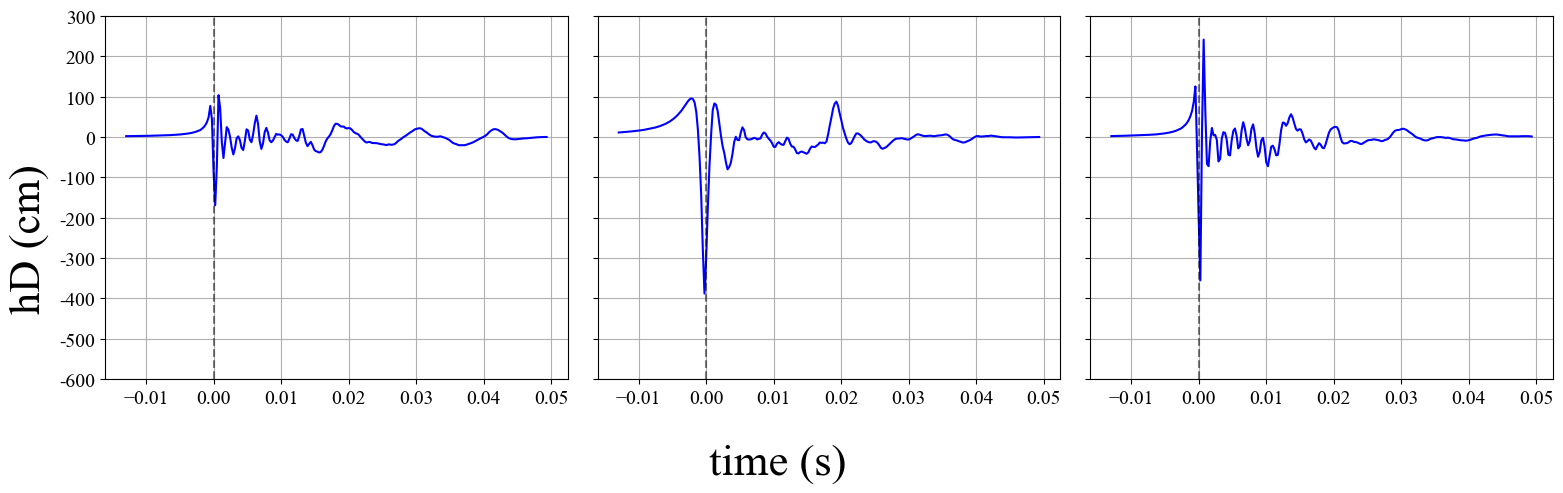

In [4]:
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'font.serif': ['Times New Roman']
})

# random_index = np.random.randint(0, generated_signals_df.shape[1], 8)
selected_signals_index = [100, 1000, 1500]
selected_signals = gw_df.iloc[:, selected_signals_index]

num_rows = 1
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 5))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = [i / 4096 for i in range(0, 256)]
    x = [value - (53/4096) for value in x]
    y = selected_signals.iloc[:, i]
    ax.set_ylim(-600, 300)
    ax.plot(x, y, color='blue')

    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.grid(True)
    
    # Set y-axis ticks
    y_ticks = np.arange(-600, 301, 100)
    x_ticks = np.arange(-0.01, 0.051, 0.01)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks)
    ax.set_xticks(x_ticks)

    # Remove y-axis ticks for the right-hand column
    if i % num_cols != 0:
        ax.yaxis.set_ticklabels([])
    
    # Remove x-axis tick labels for all but the bottom two plots
    # ax.xaxis.set_ticklabels([])

for i in range(len(selected_signals), num_rows*num_cols):
    fig.delaxes(axes[i])

# Add overall axis titles
fig.supxlabel('time (s)', fontsize=32)
fig.supylabel('hD (cm)', fontsize=32)

plt.tight_layout()
plt.savefig('../plots/real_signals_sample_3.png')
plt.show()

#### General Distribution of Signals

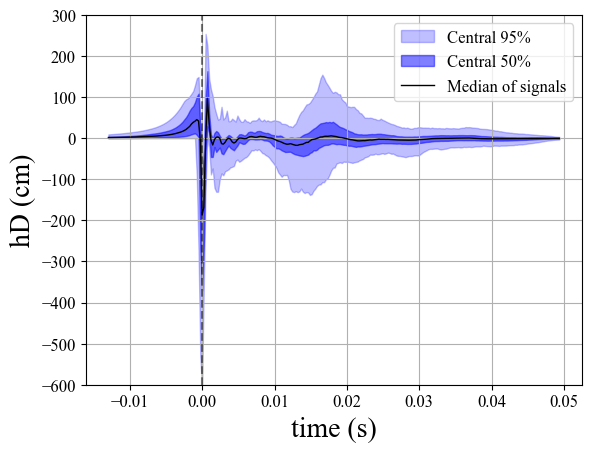

In [5]:
# Set font size globally for all plots
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman']
})

# Compute median of signals
median_line = gw_df.median(axis=1)

# Transform x values
x = [i / 4096 for i in range(0, 256)]
x = [value - (53/4096) for value in x]

# Compute central 95% interval
percentile_2_5 = gw_df.quantile(0.025, axis=1)
percentile_97_5 = gw_df.quantile(0.975, axis=1)
plt.fill_between(x, percentile_2_5, percentile_97_5, color='blue', alpha=0.25, label='Central 95%')

# Compute central 50% interval
percentile_25 = gw_df.quantile(0.25, axis=1)
percentile_75 = gw_df.quantile(0.75, axis=1)
plt.fill_between(x, percentile_25, percentile_75, color='blue', alpha=0.5, label='Central 50%')

plt.plot(x, median_line.values, color='k', linestyle='-', linewidth=1, alpha=1.0, label='Median of signals')

# The core bounce is at n = 203
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)  

# Set the same y-axis limits
plt.ylim(-600, 300)

# Set the same x-axis labels and title
plt.xlabel('time (s)', size=20)
plt.ylabel('hD (cm)', size=20)
# plt.title('Generated Stellar Core-Collapse Wave Signal Distribution', size=20)

plt.grid(True)

plt.legend()
# Save the figure
plt.savefig('../plots/original_signal_distribution_1684.png')
plt.show()

### Spectral Analysis 

#### Median of Signals

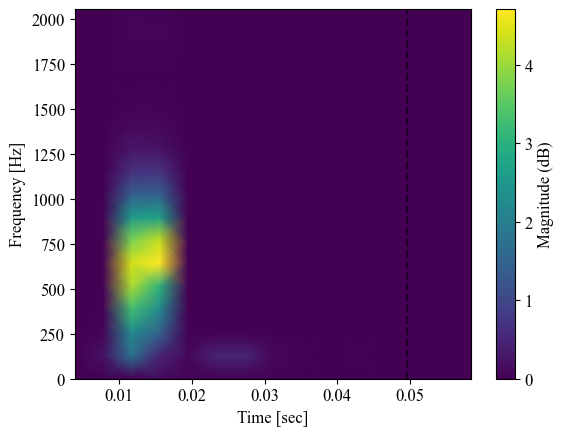

In [6]:
fs = 407/(0.04956055 * 2)
# sample_random = gw_df['V6'].values

median_gw_signals = gw_df.median(axis=1).values

window_length = 32
overlap = 16
f, t, Sxx = signal.spectrogram(median_gw_signals, fs, nperseg=window_length, noverlap=overlap)

cax = plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.colorbar(cax, label="Magnitude (dB)")

# the core bounce is at 0.04956055 s
plt.axvline(x=0.04956055, color='black', linestyle='--', alpha=0.5)  

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

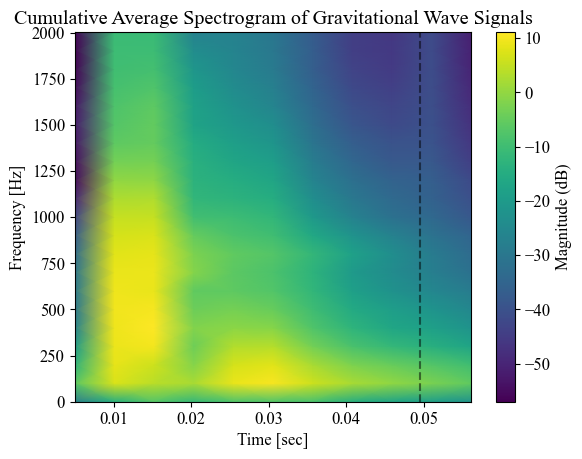

In [7]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Assuming gw_df contains your gravitational wave signals data
fs = 407 / (0.04956055 * 2)

# Initialize cumulative spectrogram with the shape of a single spectrogram
window_length = int(0.01 * fs)  # 1% of the total duration
overlap = int(0.005 * fs)  # 50% overlap
f, t, single_spectrogram = signal.spectrogram(gw_df.iloc[:, 0].values, fs, nperseg=window_length, noverlap=overlap)
cumulative_spectrogram = np.zeros_like(single_spectrogram)

# Compute the cumulative spectrogram for all signals
num_signals = len(gw_df.columns)
for i in range(num_signals):
    signal_values = gw_df.iloc[:, i].values
    _, _, Sxx = signal.spectrogram(signal_values, fs, nperseg=window_length, noverlap=overlap)
    cumulative_spectrogram += Sxx  # Sum the spectrogram of each signal

# Compute the cumulative average spectrogram
average_spectrogram = cumulative_spectrogram / num_signals

# Plot the cumulative average spectrogram
cax = plt.pcolormesh(t, f, 10 * np.log10(average_spectrogram), shading='gouraud')  # Convert to dB for better visualization
plt.colorbar(cax, label="Magnitude (dB)")

# The core bounce is at 0.04956055 s
plt.axvline(x=0.04956055, color='black', linestyle='--', alpha=0.5)

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Cumulative Average Spectrogram of Gravitational Wave Signals')
# plt.savefig('../plots/gw_cumulative_average_spectrogram.png')
plt.show()


- Range of frequency bands around core bounce
- Peak magnitude at ~700 Hz
- Posty bounce has faint frequency band from 0.06s - 0.07s at 50 Hz